In [133]:

import math
import pandas as pd #package for reading data
import numpy as np
import graphlib
import statistics
import matplotlib.pyplot as plt #package for plots
import gmplot 
from scipy import signal
from scipy import integrate

def degreesToRadians(degrees):
  return degrees * math.pi / 180


def distanceInKmBetweenEarthCoordinates(lat1, lon1, lat2, lon2):
  earthRadiusKm = 6371;

  dLat = degreesToRadians(lat2-lat1)
  dLon = degreesToRadians(lon2-lon1)

  lat1 = degreesToRadians(lat1)
  lat2 = degreesToRadians(lat2)
  
  a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2)
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  return earthRadiusKm * c

def gather_function(time_data,data1,data2):
  i = 0
  x = 0
  while i < len(time_data) - 1:
    for n in gps_time:
      if(time_data[i] <= n <=time_data[i+1]):
        data1.append(latitude[x])
        data2.append(longitude[x])
        x = x + 1
    i = i + 1 
  return [data1,data2]

def speedfn (x,y):
  i = 0
  time = y
  #value = reduce_bar
  value = x
  speed = []
  times = []
  while i <len(x)-1:
    x0, x1 = time.iat[i], time.iat[i+1]
    t = time.iat[i]
    y0, y1 = value[i], value[i+1]
    val = y1-y0
    
    if val < 0 :  # somehow abs() doesn't work
     val *= -1 
    speed.append((x1-x0)*(val))
    times.append(y0)
    i = i + 1
  speed.append(0)
  times.append(0)
  return speed

#main function
def der(x,y):
  """
  derivative of column y of sheet x
  """
  i = 0
  time = x['time']
  #value = reduce_bar
  value = x[y]
  slopes = []
  aslopes = []
  times = []

  while i < len(x)-1: 
    x0, x1 = time.iat[i], time.iat[i+1]
    t = time.iat[i]
    y0, y1 = value[i], value[i+1]
    numerator = y1-y0
    num = numerator
    if numerator < 0 :  # somehow abs() doesn't work
      numerator *= -1
    slope = numerator#/(x1-x0)
    #slope = numerator
    aslope = num# /(x1-x0)
    #aslope = num
    slopes.append(slope)
    times.append(t)
    aslopes.append(aslope)
    i+=1
  slopes.append(0)
  times.append(0)
  aslopes.append(0)
  return [slopes,times,aslopes]

def complicated(x,y):
  #x: vel , y: rounded time
  # return: mean of vel for same rounded time , corresponding time
  a = []
  b = []
  c = []
  d = []
  count = 0
  counts = []
  n = 0
  while n < max(y) :
    for i in y:
      if i == n:
        a.append(x[y.index(i)])
        c.append(i)
        count = count + 1 
    n = n + 1
    counts.append(count)
    if(len(a) == 0):
      b.append(0)
      d.append(0)
    else:
      b.append(sum(a)/len(a))
      d.append(sum(c)/len(c))
    count = 0
    a.clear()
    c.clear()
  # for i in y:
  #     if i == n:
  #       a.append(x[y.index(i)])
  #       count = count + 1 
  # n = n + 1
  # counts.append(count)
  # count = 0
  # print(sum(a))
  # print(len(a))
  # print(sum(a)/len(a))
  # b.append(mean(a))
  # a.clear()
  return [b,d]

#data 
gps_data = pd.read_csv('GPS.csv')
pressure_data = pd.read_csv('Pressure.csv')
pressure_range = pd.read_csv("Pressure_Range.csv")
acceleration_data = pd.read_csv("Acceleration.csv")
# gps_data = pd.read_csv('Data/newData/soon_gps.csv')
# pressure_data = pd.read_csv('Data/newData/soon_pressure.csv')
# pressure_range = pd.read_csv("Pressure_Range.csv")
# acceleration_data = pd.read_csv("Data/newData/soon_acc.csv")

latitude = gps_data["Latitude"]
longitude = gps_data["Longitude"]
gps_time = gps_data["time"]
gps_speed = gps_data["Speed"]
altitude = gps_data["Altitude"]

# pressure_r = pressure_range["Pressure"]
# pressure_r_t = pressure_range["time"]
# deri_pr = der(pressure_range,"Pressure")
# der_pr = deri_pr[0]
# der_prt = deri_pr[1]


bar = pressure_data["Pressure"] #pressure
bar_time = pressure_data["time"] # pressure time 
reduce_bar = signal.savgol_filter(bar,window_length=11, polyorder=1, mode="nearest")
deri = der(pressure_data,'Pressure')
der_p = deri[0] #deri func absolute slope
der_t = deri[1] # deri func time 
der_a = deri[2] #deri func slope

a_x = acceleration_data["Acceleration x"]
az =acceleration_data["Acceleration z"]
ay = acceleration_data["Acceleration y"]
aa = acceleration_data["abs Acceleration"]
at = acceleration_data["time"]

#deri_a = integrate.cumulative_trapezoid(y=aa,x=at,initial=0)
deri_a = speedfn(aa,at)

new_der_t = []
for i in der_t:
  new_der_t.append(math.floor(i))
  
new_at = []
for i in at: #at
  new_at.append(math.floor(i))

new_gps_time = []
for i in gps_time:
  new_gps_time.append(math.floor(i))

new_bar_time = []
for i in bar_time:
  new_bar_time.append(math.floor(i))

ass = complicated(deri_a,new_at)
ass_p = complicated(der_p,new_der_t)
ass_a = complicated(der_a,new_der_t)
ass_b = complicated(bar,new_bar_time)
ass_aa = complicated(aa,new_at)

# range determination
mean = statistics.mean(der_p)
std = statistics.stdev(der_p)
range0 = der_p[0] +  std

mean_a = statistics.mean(deri_a)
max_a = max(deri_a)
min_a = min(deri_a)
range2 = mean_a
range1 = (max_a + mean_a)/2
range3 = (min_a + mean_a)/2

#range = der_pr[0]

# Gathering elevated Data
at1 = []
at2 = []
at3 = []
at4 = []
a1 = []
a2 = []
a3 = []
a4 = []
for i in ass[0]:
  if i<range3:
    at1.append(ass[1][ass[0].index(i)])
    a1.append(i)
  elif range3<=i<range2:
    at2.append(ass[1][ass[0].index(i)])
    a2.append(i)
  elif range2<=i<range1:
    at3.append(ass[1][ass[0].index(i)])
    a3.append(i)
  elif i>= range1:
    at4.append(ass[1][ass[0].index(i)])
    a4.append(i)

range_p = [] #elevated altitude changes 
range_p_flat = [] #flat altitude changes 
range_t = [] #time for elevated altitude changes
range_t_flat = []
range_a = []
range_a_flat = []
for i in ass_p[0]:
  if i >= range0:
    range_p.append(i)
    range_t.append(ass_p[1][ass_p[0].index(i)])
    range_a.append(ass_a[0][ass_p[0].index(i)])
  else:
    range_p_flat.append(i)
    range_t_flat.append(ass_p[1][ass_p[0].index(i)])
    range_a_flat.append(ass_a[0][ass_p[0].index(i)])
# for i in der_p:
#   if i >= range:
#     range_p.append(i)
#     range_t.append(der_t[der_p.index(i)])
#     range_a.append(der_a[der_p.index(i)])
#   else:
#     range_p_flat.append(i)
#     range_t_flat.append(der_t[der_p.index(i)])
#     range_a_flat.append(der_a[der_p.index(i)])


up_time = []
down_time = []
flat_time = []
for n in range_a:
  if n < 0:
    up_time.append(range_t[range_a.index(n)])
  elif n>0:
    down_time.append(range_t[range_a.index(n)])

In [134]:
def new_gather_function(time_data,time_gps):
  i = 0
  data1 = []
  data2 = []
  while i < len(time_data) :
    for n in time_gps:
      if(time_data[i] == n):
        data1.append(latitude[time_gps.index(n)])
        data2.append(longitude[time_gps.index(n)])
    i = i + 1 
  # while i < len(time_data):
  #   if time_data[i]==time_gps[i]:
  #       data1.append(latitude[i])
  #       data2.append(longitude[i])
  #   i = i + 1
  return [data1,data2]

#Gathering co-ordinates of elevated data
a1_c = new_gather_function(at1,new_gps_time)
a2_c = new_gather_function(at2,new_gps_time)
a3_c = new_gather_function(at3,new_gps_time)
a4_c = new_gather_function(at4,new_gps_time)


up_co = []
down_co = []
flat_co = []
up_co = new_gather_function( up_time,new_gps_time)
down_co = new_gather_function(down_time,new_gps_time)
flat_co = new_gather_function(range_t_flat,new_gps_time)
# for i in range_t:
#   for n in gps_time:
#     if (i <= n <= ):
#       gps_hill_la.append(latitude[range_t.index(i)])
#       gps_hill_lo.append(longitude[range_t.index(i)])
# there might be an issue in co-ordinate selection

#making the map
lat = latitude.iat[0]
log = longitude.iat[0]

m = 0
dist = 0
while (m < len(latitude)-1):
  dist1 = distanceInKmBetweenEarthCoordinates(latitude.iat[m],longitude.iat[m],latitude.iat[m+1],longitude.iat[m+1])
  dist = dist + dist1
  m = m + 1;

print('Total Distance = ', dist)
printDist = str(dist)

gmap1 = gmplot.GoogleMapPlotter(lat, log, zoom=18)
gmap1.plot(latitude, longitude, '#000000', size = 0.5, marker = False )
gmap1.marker(latitude[0],longitude[0], color='cornflowerblue')
# gmap.scatter(gps_hill_la, gps_hill_lo, '#16EBF9', size = 0.5, marker = False  )
gmap1.scatter(up_co[0], up_co[1], '#FFFFFF', size = 0.4, marker = False  )
gmap1.scatter(down_co[0], down_co[1], '#6CE6FF', size = 0.4, marker = False  )
gmap1.scatter(flat_co[0], flat_co[1], '#F90101', size = 0.4, marker = False  )
gmap1.text(latitude[0],longitude[0],'Total Distance is: '+ printDist + 'km', color = '#9EF901', font_size = 150)


gmap = gmplot.GoogleMapPlotter(lat, log, zoom=18)
gmap.plot(latitude, longitude, '#FFFFFF', size = 0.3, marker = False )
gmap.marker(latitude[0],longitude[0], color='cornflowerblue')
gmap.scatter(a1_c[0],a1_c[1], '#9EF901', size = 0.4, marker = False  )
gmap.scatter(a2_c[0],a2_c[1], '#F9CF01', size = 0.4, marker = False  )
gmap.scatter(a3_c[0],a3_c[1], '#F98001', size = 0.4, marker = False  )
gmap.scatter(a4_c[0],a4_c[1], '#F90101', size = 0.4, marker = False  )



# a4 = red  (#F90101)
# a3 = orange (#F98001)
# a2 = yellow (#F9CF01)
# a1 = green (#9EF901)

# uphill = white (#FFFFFF)
# downhill = blue (#6CE6FF)

gmap1.draw("gps_mapping.html")
gmap.draw( "mapping.html" )

Total Distance =  0.8240424119460332


In [135]:
#Debugging
# print('gps_time: ',len(gps_time))
# print(gps_time)
# print('new gps time: ',len(new_gps_time))
# print(new_gps_time)
# print('\n')

# print('a1:',len(a1))
# print(a1)
# print('at1:',len(at1))
# print(at1)
# print('a1_c:',len(a1_c[0]))
# print(a1_c)
# print('\n')

# print('a2:',len(a2))
# print(a2)
# print('at2:',len(at2))
# print(at2)
# print('a2_c:',len(a2_c[0]))
# print(a2_c)
# print('\n')

# print('a3:',len(a3))
# print(a3)
# print('at3:',len(at3))
# print(at3)
# print('a3_c:',len(a3_c[0]))
# print(a3_c[0])
# print('\n')

# print('a4:',len(a4))
# print(a4)
# print('at4:',len(at4))
# print(at4)
# print('a4_c:',len(a4_c[0]))
# print(a4_c[0])
# print('\n')

# print(len(at1) + len(at2) + len(at3) + len(at4))
# print(len(a1_c[0])+len(a2_c[0])+len(a3_c[0])+len(a4_c[0]))
# print(len(latitude))


433
433


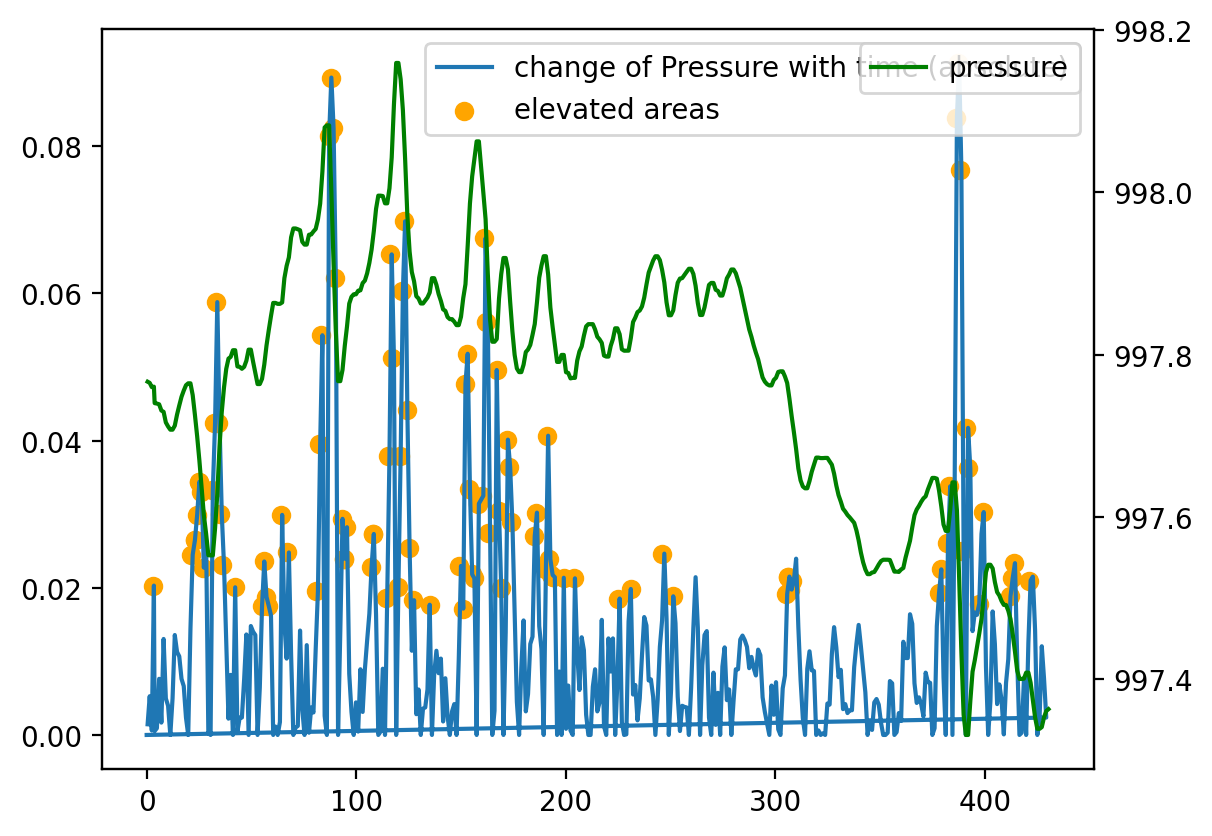

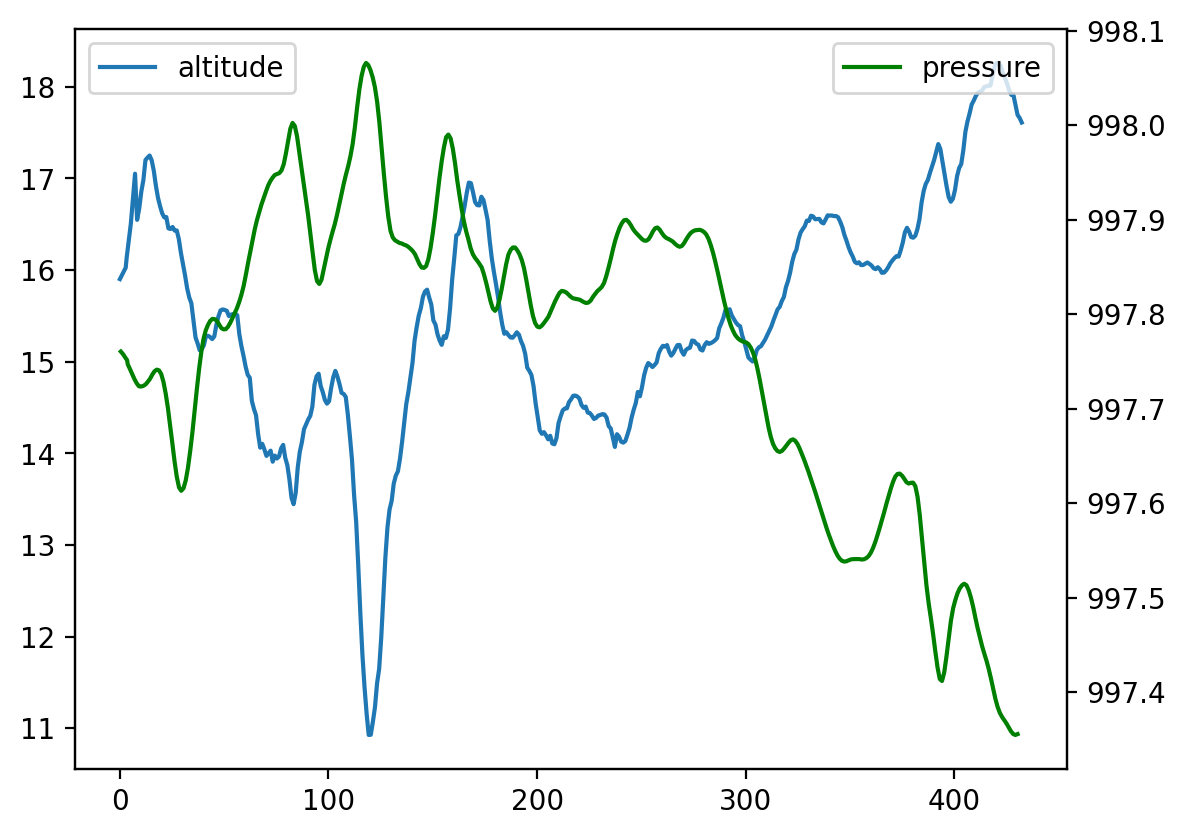

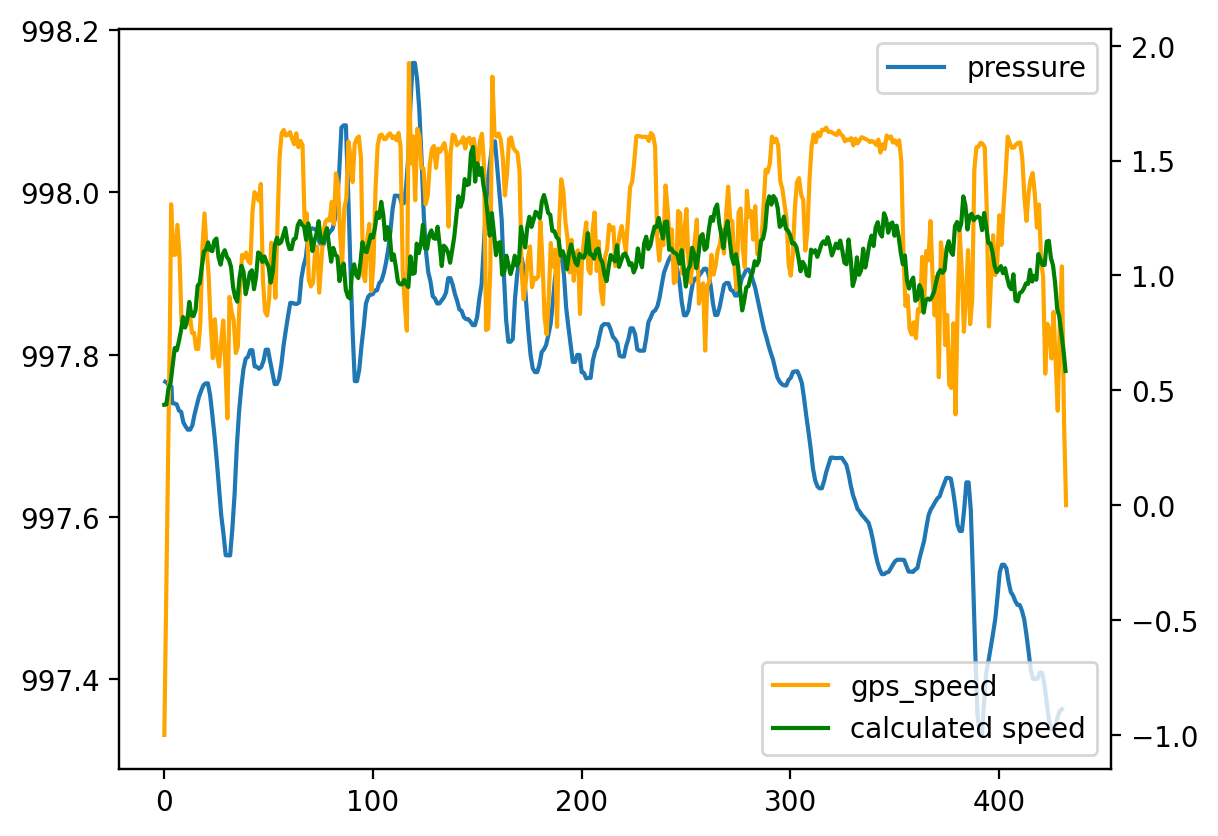

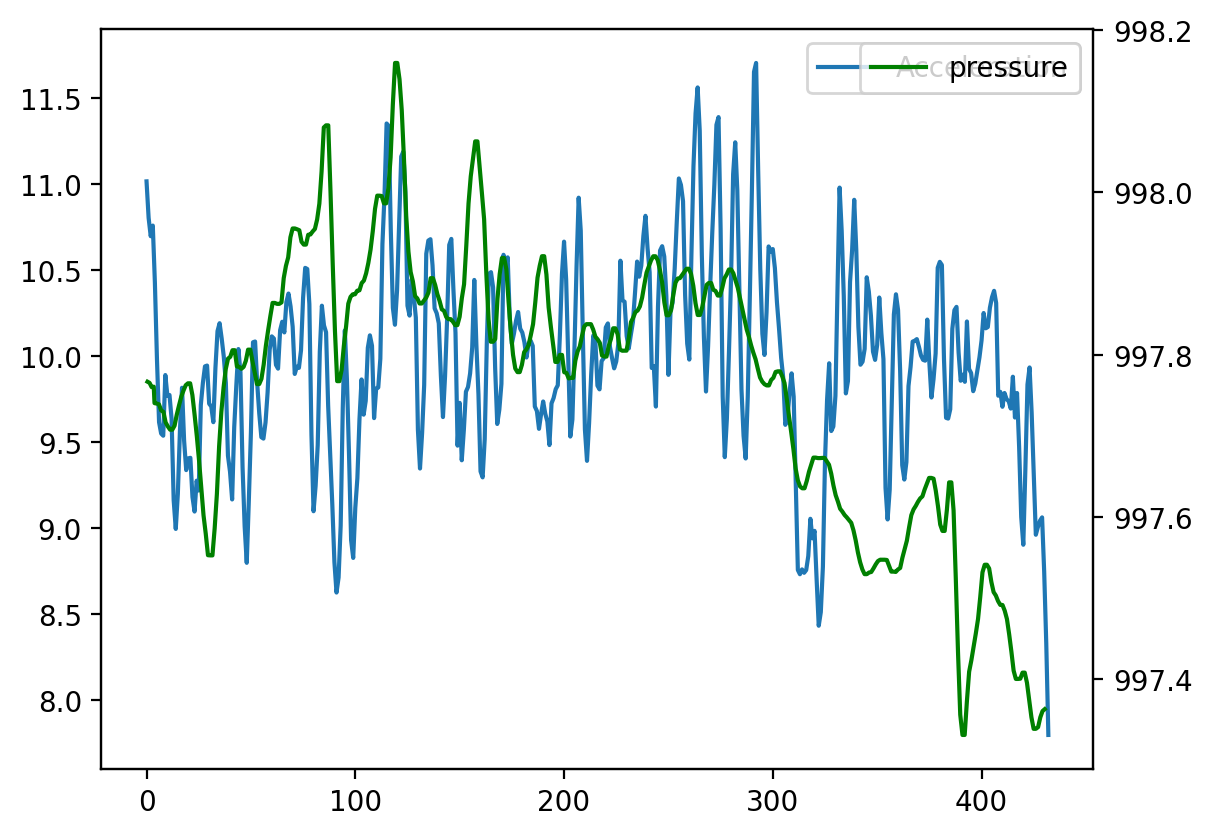

In [136]:
#Plotting data

# p v acc
print(len(ass_aa[0]))
print(len(ass_aa[1]))

#p v absolute deri + scatter(elevated points)
fig, ax = plt.subplots()
fig.set_dpi(200)
# use these two lines for der_a i.e change of pressure with normal values 
# ax.plot(der_t,der_a,label='change of Pressure with time (with signs)')
# ax.scatter(range_t,range_a,color = 'orange',label = 'elevated areas')
ax.plot(der_t,der_p,label='change of Pressure with time (absolute)')
ax.scatter(range_t,range_p,color = 'orange',label = 'elevated areas')
ax.legend()
ax2 = ax.twinx()
ax2.plot(bar_time,bar,color='green',label='pressure')
ax2.legend()
plt.show()

#filtered graph of altitude values from gps sensor vs pressure values from barometer 
reduce_altitude = signal.savgol_filter(altitude,window_length=11, polyorder=1, mode="nearest")
reduce_bar = signal.savgol_filter(bar,window_length=11, polyorder=1, mode="nearest")
fig2, ax3 = plt.subplots()
fig2.set_dpi(200)
ax3.plot(gps_time,reduce_altitude, label="altitude")
ax3.legend()
ax4 = ax3.twinx()
ax4.plot(bar_time,reduce_bar,color='green',label="pressure")
ax4.legend()
plt.show()

# pressure vs speed (gps_speed + calculated_speed)
reduce_ass = signal.savgol_filter(ass[0],window_length=15, polyorder=1, mode="nearest")
fig3,ax6 = plt.subplots()
fig3.set_dpi(200)
ax6.plot(bar_time,bar,label='pressure')
ax6.legend()
ax7 = ax6.twinx()
ax7.plot(gps_time,gps_speed,label='gps_speed',color='orange')
ax7.plot(ass[1],reduce_ass,label = 'calculated speed',color='green')
ax7.legend()
plt.show()

# pressure vs acceleration 
reduce_aa = signal.savgol_filter(ass_aa[0],window_length=15, polyorder=1, mode="nearest")
fig3,ax5 = plt.subplots()
fig3.set_dpi(200)
ax5.plot(ass_aa[1],reduce_aa,label='Acceleration')
ax5.legend()
ax8 = ax5.twinx()
ax8.plot(bar_time,bar,label='pressure',color='green')
ax8.legend()





